# Prototyping the Swept Langmuir Diagnostic

This notebook will focus on the mechanics of operating on 2D DataArrays where one dimension is `shot_index` and the second is `time_index`.  **This notebook is for prototyping purposes and will either be deleted or converted into a documentaiton notebook when the protoyping is finished.**

### Table of Contents

1. [Import Packages](#Import-Packages)
1. [Enable the Swept Langmuir Diagnostic](#Enable-the-Swept-Langmuir-Diagnostic)
1. [Build the `xarray.Dataset`](#Build-the-xarray.Dataset)

## Import Packages

In [1]:
%matplotlib inline

import astropy.units as u
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

from numbers import Number
from typing import Mapping, Hashable, Any
from warnings import warn
from xarray.core.utils import either_dict_or_kwargs
from xarray.core.coordinates import remap_label_indexers

from plasmapy import __file__ as plasmapy_file
from plasmapy.diagnostics import xdiagnostics
from plasmapy.utils.exceptions import PlasmaPyError, PlasmaPyWarning

plasmapy_dir = os.path.dirname(os.path.abspath(plasmapy_file))

## Enable the Swept Langmuir Diagnostic

By default `plasmapy` does not register any of its `xarray.Dataset` accessors to avoid polution of the namespace and reduce overhead of importing unnecessary code.  Instead, we provide the `xdiagnostics` object so the user can enable the `xarray.Dataset` accessor(s) he or she wants.  Just executing `xdiagnostics` will show what diagnosics are available and enabled/disabled.

In [2]:
xdiagnostics


Enabled   Available Diagnostic   Bound As
    [ ]   swept_langmuir         

In [3]:
hasattr(xr.Dataset, "swept_langmuir")

False

In [4]:
# xdiagnostics.enable('swept_langmuir')
xdiagnostics.enable('swept_langmuir', rename="slang")
xdiagnostics


Enabled   Available Diagnostic   Bound As
    [x]   swept_langmuir         slang

In [5]:
(hasattr(xr.Dataset, "swept_langmuir"),
 hasattr(xr.Dataset, "slang"),
)

(False, True)

## Build the `xarray.Dataset`

- The `Dataset` needs to have two `DataArray`s named `voltage` and `current`.
- The `DataArray`'s are either 1D or 2D.
- The `DataArray`'s have to have matching `dims` and `shape`.
- The names of the dimesions do not matter, since the **diagnostic** is agnostic towards the names but the order does matter.
  - Dims for 1D: `dims=["time_index"]`
  - Dims for 2D: `dims=["signal_index", "time_index"]`

In [22]:
# Load the bias and current values stored in the example file
path = os.path.abspath(os.path.join(
    plasmapy_dir, '..','docs', "notebooks", "langmuir_samples", "Beckers2017.npy"
))
bias, current = np.load(path)
bias = np.tile(bias, (4, 1))
current = np.tile(current, (4, 1))

# voltage DataArray
da_volt = xr.DataArray(bias,
                       dims=['shotnum', 'time'],
                       name='voltage')

# current DataArray
da_curr = xr.DataArray(current,
                       dims=['shotnum', 'time'],
                       name='current')

# Build coordinate arrays
shotnum = np.arange(10, 14)
time = np.arange(bias.shape[1]) * 0.1


# build dataset
ds = xr.Dataset(
    {da_volt.name: da_volt,
     da_curr.name: da_curr},
#     coords={"shotnum": ("shotnum", shotnum),
#             "time": ("time", time)},
        coords={"shotnum": ("shotnum", shotnum)},
)

# initialize Dataset with swept langmuir components
ds.slang

# artificlaly adjust start and stop indices for shotnum 11
ds["id_wstart"].loc[dict(id={"id_signum": 11, "id_swpnum": 0})] = 100 # * 0.1
ds["id_wstop"].loc[dict(id={"id_signum": 11, "id_swpnum": 0})] = 200 # * 0.1

# show dataset
ds

<xarray.Dataset>
Dimensions:    (id: 4, shotnum: 4, time: 304)
Coordinates:
  * shotnum    (shotnum) int64 10 11 12 13
  * id         (id) MultiIndex
  - id_signum  (id) int64 10 11 12 13
  - id_swpnum  (id) int64 0 0 0 0
    id_wstart  (id) int64 0 100 0 0
    id_wstop   (id) int64 303 200 303 303
Dimensions without coordinates: time
Data variables:
    voltage    (shotnum, time) float64 -30.57 -30.45 -30.33 ... 6.165 6.287
    current    (shotnum, time) float64 -0.002315 -0.002311 ... 0.03101 0.03104

In [15]:
ds.sel(id=(11, 0))

<xarray.Dataset>
Dimensions:    (shotnum: 4, time: 304)
Coordinates:
  * shotnum    (shotnum) int64 10 11 12 13
  * time       (time) float64 0.0 0.1 0.2 0.3 0.4 ... 29.9 30.0 30.1 30.2 30.3
    id         object (11, 0)
    id_wstart  float64 10.0
    id_wstop   float64 20.0
Data variables:
    voltage    (shotnum, time) float64 -30.57 -30.45 -30.33 ... 6.165 6.287
    current    (shotnum, time) float64 -0.002315 -0.002311 ... 0.03101 0.03104

### Select a Sweep based in its ID

In [21]:
indexers = ds.slang.sel_indexers(id=(11,0))
print(indexers)
ds.slang.sel(id=(11, 0))
# ds.loc[indexers]

{'id': (11, 0), 'shotnum': array(11), 'time': slice(10.0, 20.0, None)}


<xarray.Dataset>
Dimensions:    (time: 101)
Coordinates:
    shotnum    int64 11
  * time       (time) float64 10.0 10.1 10.2 10.3 10.4 ... 19.7 19.8 19.9 20.0
    id         object (11, 0)
    id_wstart  float64 10.0
    id_wstop   float64 20.0
Data variables:
    voltage    (time) float64 -18.41 -18.28 -18.16 ... -6.485 -6.364 -6.242
    current    (time) float64 -0.00185 -0.001843 ... -0.0002795 -0.0002307

In [8]:
# How many sweeps does signal number 11 have?
ds.slang.sweep_count(11)

1

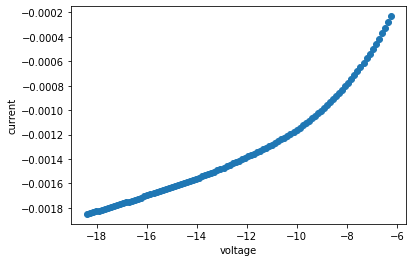

In [9]:
ds.slang.sel(id=(11, 0)).plot.scatter(x='voltage', y='current')

The sweep window can be overridden

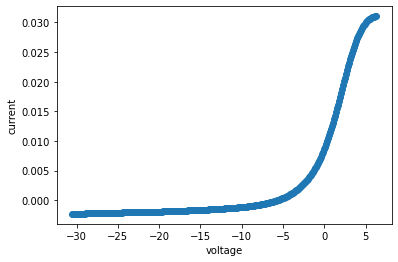

In [10]:
ds.slang.sel(id=(11, 0), time=slice(None)).plot.scatter(x='voltage', y='current')

In [17]:
def smooth(a, window_len=10):
    s=np.r_[a[window_len-1:0:-1], a, a[-2:-window_len-1:-1]]
    w = np.ones(window_len, 'd')
    sm = np.convolve(w / w.sum(), s, mode='valid')
    return sm

smooth(ds.slang.sel(id=(11, 0)).current)

array([-0.00181913, -0.00182477, -0.001829  , -0.00183182, -0.00183323,
       -0.00183323, -0.00183182, -0.001829  , -0.00182477, -0.00181913,
       -0.00181207, -0.00180492, -0.00179768, -0.00179035, -0.00178291,
       -0.00177537, -0.00176773, -0.00175997, -0.0017521 , -0.00174411,
       -0.00173601, -0.00172779, -0.00171947, -0.00171105, -0.00170255,
       -0.00169398, -0.00168538, -0.00167675, -0.00166812, -0.00165951,
       -0.00165093, -0.00164239, -0.0016339 , -0.00162545, -0.00161703,
       -0.0016086 , -0.00160014, -0.00159163, -0.00158302, -0.00157427,
       -0.00156536, -0.00155626, -0.00154694, -0.00153739, -0.0015276 ,
       -0.00151757, -0.0015073 , -0.00149681, -0.00148613, -0.00147526,
       -0.00146425, -0.0014531 , -0.00144186, -0.00143054, -0.00141916,
       -0.00140772, -0.00139624, -0.0013847 , -0.00137309, -0.00136139,
       -0.00134956, -0.00133757, -0.00132537, -0.00131293, -0.00130018,
       -0.00128709, -0.00127362, -0.00125974, -0.00124541, -0.00

In [12]:
# midx = pd.MultiIndex.from_tuples([(10, 0),
#                                   (11, 0),
#                                   (11, 1)], names=["sid", "tid"])
# midx
# ds.coords["id"] = ("id", midx)
# ds.coords["id_num"] = ("id", np.arange(ds.coords["id"].size))
# ds.coords

def sel_(ds, indexers: Mapping[Hashable, Any] = None, method: str = None, tolerance: Number = None, drop: bool = False, **indexers_kwargs: Any) -> Mapping[Hashable, Any]:
    _shot_index = "shotnum"
    _time_index = "time_index"
    _id_index = "id"
    _id_shot = "s" + _id_index
    _id_trace = "tr" + _id_index
    _id_wstart = _id_index + "_wstart"
    _id_wstop = _id_index + "_wstop"
    
    indexers = either_dict_or_kwargs(indexers, indexers_kwargs, "swept_langmuir.index")

    if _id_index in indexers and _shot_index in indexers:
        print(f"{_id_index} and {_shot_index}")
        
        raise ValueErrors(
            f"I'm not smart enough to resolve indexing using both {_id_index} and "
            f"{_shot_index}, use just one."
        )
    elif _id_index in indexers:
        # generate sel for shot index
        sn = ds[_id_shot].sel({_id_index: indexers[_id_index]}).data
        indexers[_shot_index] = sn
        
        # generate sel for time index
        if _time_index in indexers:
            # let the id time interval be overruled by _time_index
            pass
        else:
            wstart = ds[_id_wstart].sel({_id_index: indexers[_id_index]}).data
            wstop = ds[_id_wstop].sel({_id_index: indexers[_id_index]}).data
            indexers[_time_index] = slice(np.min(wstart), np.max(wstop))
    elif _shot_index in indexers and _time_index in indexers:
        # need to filter for both sid's and trid's
        
        # get shot index values
        sn = indexers[_shot_index]
        
        # get trace index values
        # pick id's where any time value falls between wstart and wstop
#         mask = xr.where((ds[_id_wstart] >= np.min(indexers[_time_index])) 
#                         & (ds[_id_wstop] <= np.max(indexers[_time_index])), True, False).data
        warn(f"I'm not smart enough to select trace id's '{_id_trace}' based on ""
             f"time index '{_time_index}' values.  Only filtering for shot index values", PlasmaPyWarning)
        
    elif _shot_index in indexers:
        # need to filter for sid only
        pass
    elif _time_index in indexers:
        # need to filert for trid only
        pass

#     pos_indexers, new_indexes = remap_label_indexers(
#         ds, indexers=indexers, method=method, tolerance=tolerance
#     )
#     result = ds.isel(indexers=pos_indexers, drop=drop)
#     return result._overwrite_indexes(new_indexes)
#     return ds

#     return ds.sel(indexers=indexers, method=method, tolerance=tolerance, drop=drop)
    return indexers

# ds.sel(id={"sid": 11, "trid": 0})
# indexers = index(ds, id={"sid": 11, "trid": 0})
indexers = sel_(ds, id=([10],))
# sn = ds["sid"].sel(indexers).data
# ds.sel(shotnum=sn)
# ds["id"].sel(id=slice(15))
print(indexers)
ds.sel(indexers).plot.scatter(x="voltage", y="current")

SyntaxError: EOL while scanning string literal (<ipython-input-12-fe020b770477>, line 50)

In [242]:
mask = xr.where((ds.coords["id_wstart"] >= 50) & (ds.coords["id_wstop"] <= 300), True, False).data
ds["trid"][mask].data

array([0])

In [184]:
# data = ds.sel(id={"sid": 11, "trid": 0})
data = ds["id"].sel(id=([11, 12], [0]))
# data = ds["id"].isel(id=0)
# data["id"].data.tolist()
# ds

# dir(data["id"].data)


# data["id"].data

data

<xarray.DataArray 'id' (id: 2)>
array([(11, 0), (12, 0)], dtype=object)
Coordinates:
  * id         (id) MultiIndex
  - sid        (id) int64 11 12
  - trid       (id) int64 0 0
    id_wstart  (id) int64 100 0
    id_wstop   (id) int64 200 304

In [11]:
ds.coords["pname"] = ("pname", ["vf", "Isat", "Te", "vp"])
ds.coords["pquantity"] = ("pquantity", ["value", "error"])
ds["parameters"] = (("id", "pname", "pquantity"), np.tile(np.nan, (ds["id"].size, ds["pname"].size, ds["pquantity"].size)))
ds

<xarray.Dataset>
Dimensions:     (id: 4, pname: 4, pquantity: 2, shot_index: 4, time_index: 304)
Coordinates:
    shotnum     (shot_index) int64 10 11 12 13
  * id          (id) int64 0 1 2 3
    id_ishot    (id) int64 0 1 2 3
    id_wstart   (id) int64 0 0 0 0
    id_wstop    (id) int64 304 304 304 304
  * pname       (pname) <U4 'vf' 'Isat' 'Te' 'vp'
  * pquantity   (pquantity) <U5 'value' 'error'
Dimensions without coordinates: shot_index, time_index
Data variables:
    voltage     (shot_index, time_index) float64 -30.57 -30.45 ... 6.165 6.287
    current     (shot_index, time_index) float64 -0.002315 -0.002311 ... 0.03104
    parameters  (id, pname, pquantity) float64 nan nan nan nan ... nan nan nan

In [18]:
ds.slang.sel(id=(11,0))


<xarray.Dataset>
Dimensions:    (shotnum: 4, time_index: 304)
Coordinates:
  * shotnum    (shotnum) int64 10 11 12 13
    id         object (11, 0)
    id_wstart  int64 100
    id_wstop   int64 200
Dimensions without coordinates: time_index
Data variables:
    voltage    (shotnum, time_index) float64 -30.57 -30.45 ... 6.165 6.287
    current    (shotnum, time_index) float64 -0.002315 -0.002311 ... 0.03104

In [8]:
ds.voltage.dims == ds.current.dims
ds.voltage.shape


(4, 304)

In [9]:
f"voltage {ds.voltage.shape}"

'voltage (4, 304)'

In [65]:
ds["id"].size

3

In [61]:
pd.MultiIndex.from_product([ds["time_index"], [0]], names=["sid", "trid"])

MultiIndex([(  0, 0),
            (  1, 0),
            (  2, 0),
            (  3, 0),
            (  4, 0),
            (  5, 0),
            (  6, 0),
            (  7, 0),
            (  8, 0),
            (  9, 0),
            ...
            (294, 0),
            (295, 0),
            (296, 0),
            (297, 0),
            (298, 0),
            (299, 0),
            (300, 0),
            (301, 0),
            (302, 0),
            (303, 0)],
           names=['sid', 'trid'], length=304)

In [6]:
np.repeat(0, 5)

array([0, 0, 0, 0, 0])

In [13]:
ds.coords["id"] = np.arange(ds.current.shape[0])

In [21]:
# del ds["id"]
# ds.expand_dims("id")
# ds.coords["id"] = ("id", [0])
# ds.assign_coords({
#     "id_istop": ("id", np.array([0])),
# })
ds.coords["id_start"] = ("id", [5])
ds

<xarray.Dataset>
Dimensions:   (id: 1, shot_index: 4, time_index: 304)
Coordinates:
    shotnum   (shot_index) int64 10 11 12 13
  * id        (id) int64 0
    id_start  (id) int64 5
Dimensions without coordinates: shot_index, time_index
Data variables:
    voltage   (shot_index, time_index) float64 -30.57 -30.45 ... 6.165 6.287
    current   (shot_index, time_index) float64 -0.002315 -0.002311 ... 0.03104

In [ ]:
names = data.dtype.names
del names['signal']

xa = xr.DataArray(data['signal'], dims=["shotnum", "time"], name="rename")

for name in names:
    if name = 'xyz':
        pass
    else:
        xa.coord[name] = data[name]
    